In [49]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import scipy.stats

import util


FOLDER = "/Users/brendan/Projects/trails/data/"

datafiles = [
    "cost-angles|2025-08-01/data.json",
    "cost-angles|2025-08-02/data.json",
]

In [50]:
df = pd.concat([
    util.load_data(FOLDER + datafile) for datafile in datafiles
])
util.describe(df)

ratios: [100.0]
patch recovery: [0.001]
max costs: [1.25 1.5 2.0 3.0 5.0 9.0 17.0 33.0 65.0]
boundary conditions: ['SOLID']
num locations: [10 20]
random walker seeds: 4
random locations seeds: 2
patch recovery logic: ['LINEAR']
settings.searchStrategy : ['KANAI_SUZUKI']
steps: 20000
Index(['averageTravelCost', 'averageTravelLength', 'totalImprovement',
       'thresholdImprovement', 'steps', 'paths', 'weightedHeadings',
       'avgHeading', 'avgSquareHeading', 'patches',
       'settings.patchImprovement', 'settings.patchRecovery',
       'settings.maxCost', 'settings.boundaryConditions',
       'settings.numLocations', 'settings.randomSeedWalkers',
       'settings.randomSeedLocations', 'settings.recoveryLogic',
       'settings.improvementLogic', 'settings.searchStrategy', 'ratio'],
      dtype='object')


In [58]:
def plot_patches(df, IM_PER_ROW=9, MAX_IMAGES=32):

    if len(df) < MAX_IMAGES:
        MAX_IMAGES = len(df)

    fig, axs = plt.subplots(math.ceil(MAX_IMAGES / IM_PER_ROW), IM_PER_ROW)
    for i in range(MAX_IMAGES):
        ax = axs[i//IM_PER_ROW, i%IM_PER_ROW]
        ax.imshow(np.reshape(df["patches"].iloc[i], (100, 100)), cmap="inferno")
        ax.axis('off')
    plt.show()

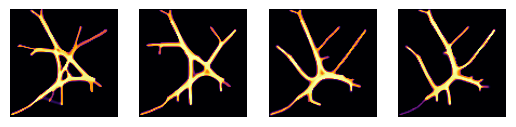

In [79]:
_df = df[
    # (df["settings.maxCost"] == 1.25) &
    (df["steps"] == 10000) &
    (df["settings.randomSeedLocations"] == 1) &
    (df["settings.randomSeedWalkers"] == 4) &
    (df["settings.numLocations"] == 20)]

fig, axs = plt.subplots(1, 4)
for i in range(4):
    axs[i].imshow(np.reshape(_df["patches"].iloc[2 * i + 2], (100, 100)), cmap="inferno")
    axs[i].axis('off')

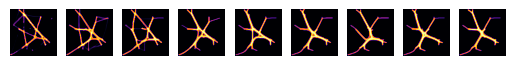

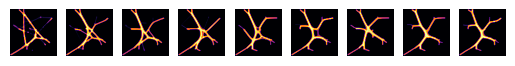

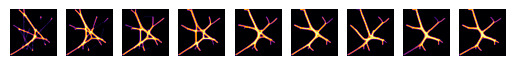

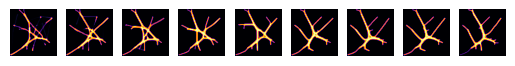

In [64]:


for i in range(1, 5):
    plot_patches(
    df[
    # (df["settings.maxCost"] == 1.25) &
    (df["steps"] == 10000) &
    (df["settings.randomSeedLocations"] == 1) &
    (df["settings.randomSeedWalkers"] == i) &
    (df["settings.numLocations"] == 20)
]);

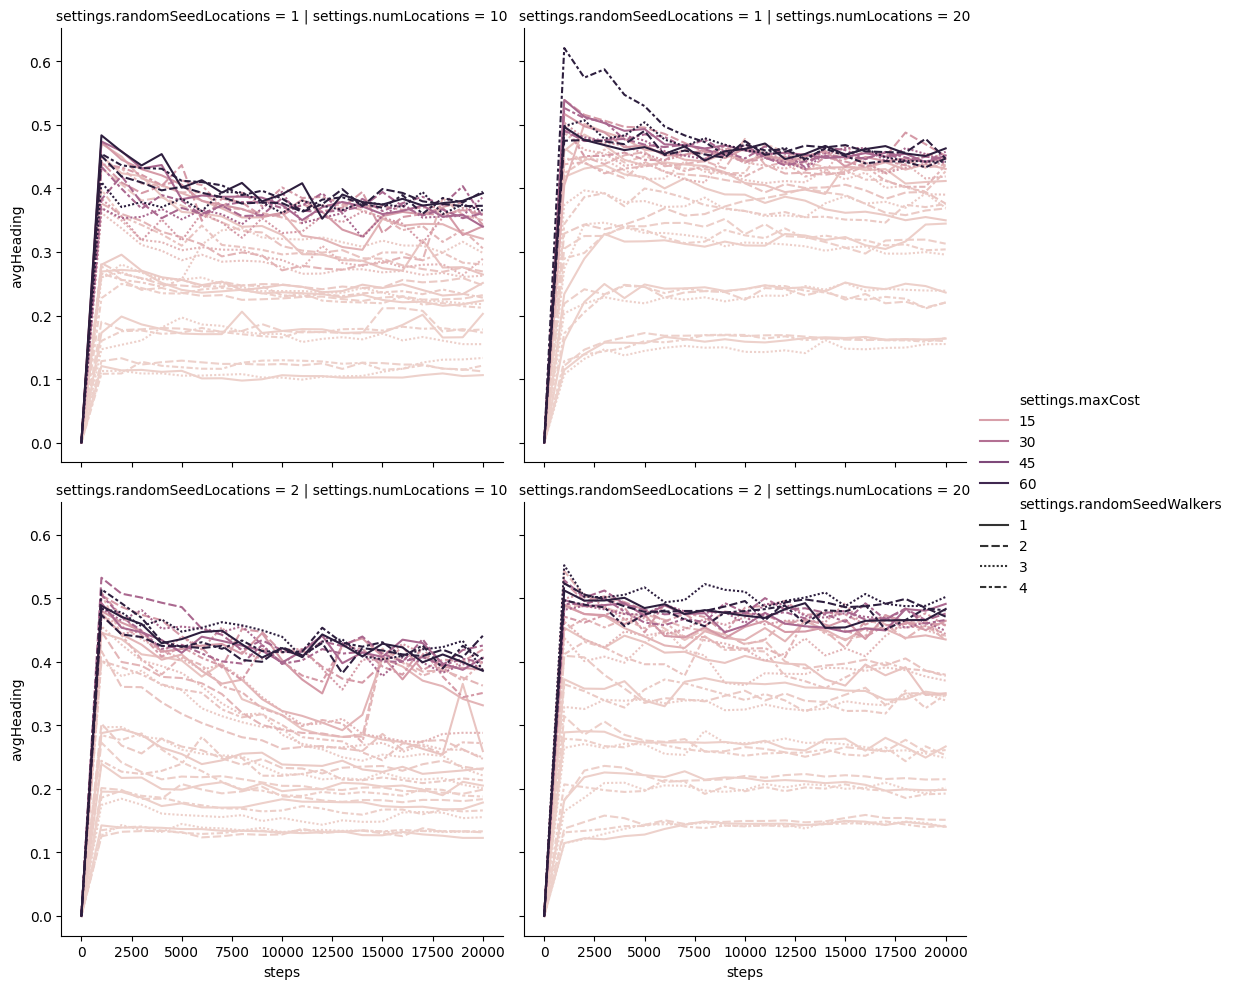

In [33]:
sns.relplot(data=df, kind="line",
         y="avgHeading", x="steps",
         hue="settings.maxCost", col="settings.numLocations",
         row="settings.randomSeedLocations", style="settings.randomSeedWalkers",
        )

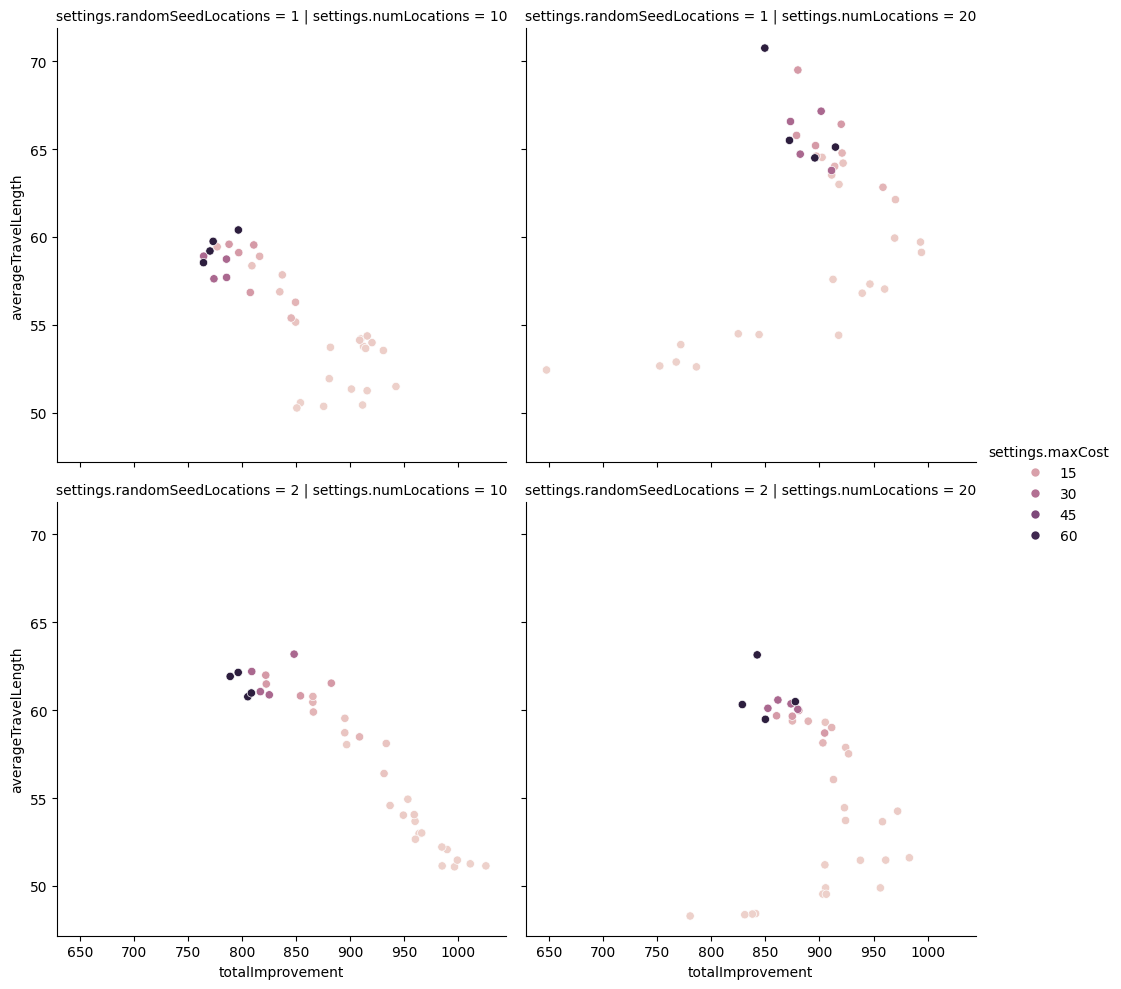

In [48]:
sns.relplot(data=df[df["steps"] == 5000],
            hue="settings.maxCost", x="totalImprovement", y="averageTravelLength",
            col="settings.numLocations", row="settings.randomSeedLocations")



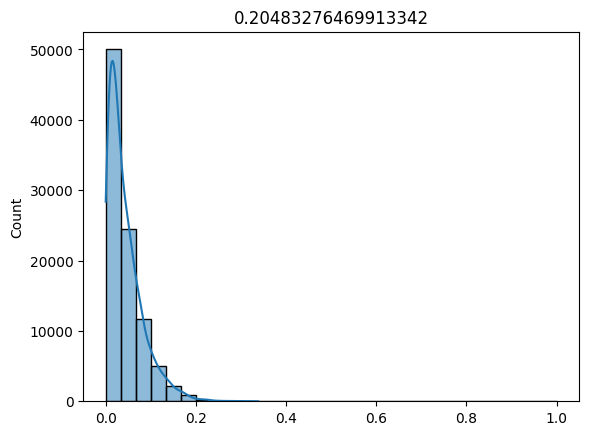

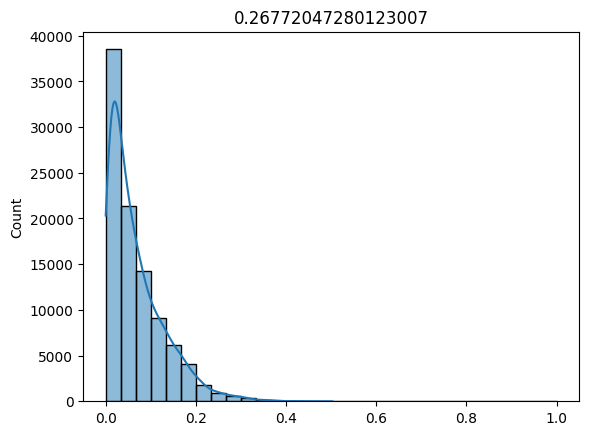

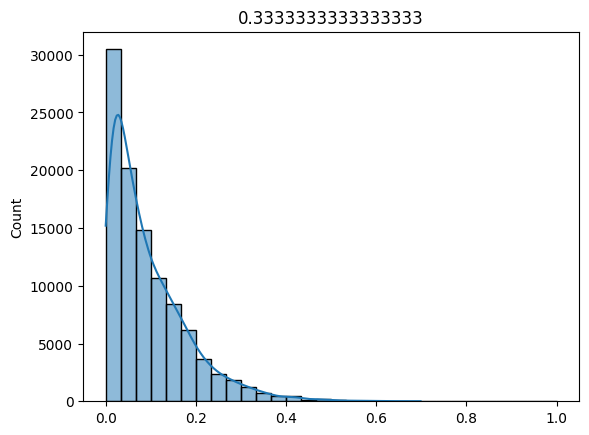

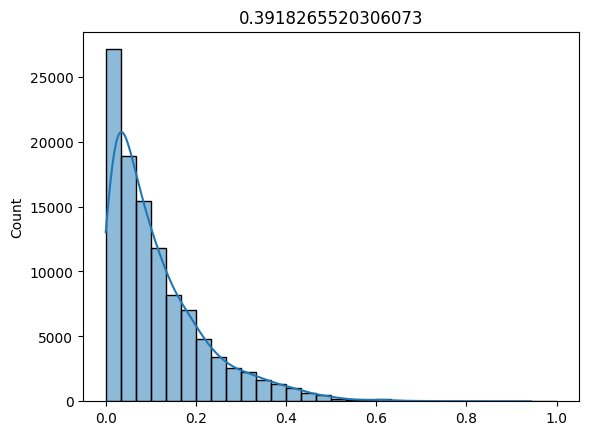

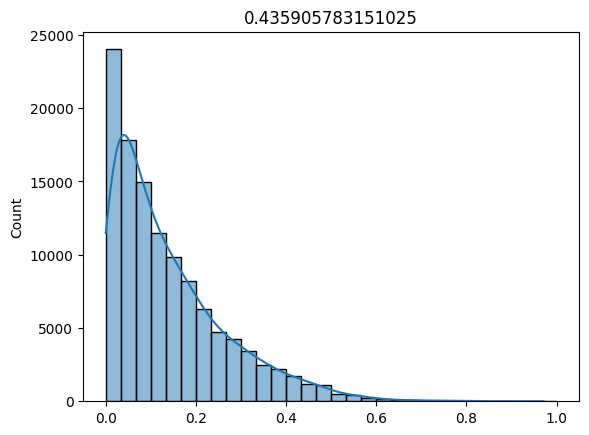

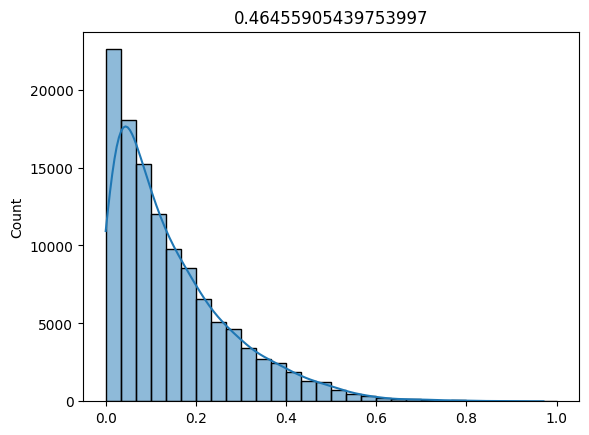

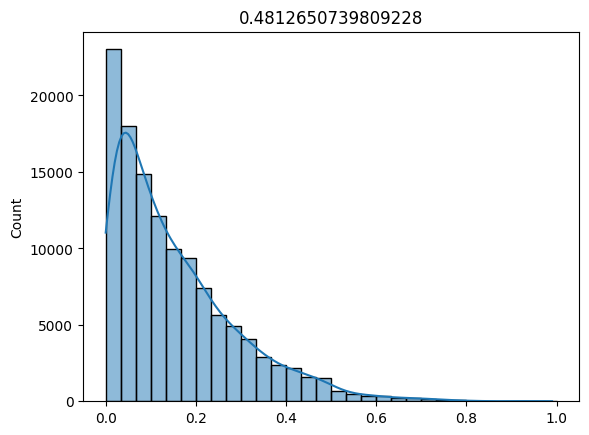

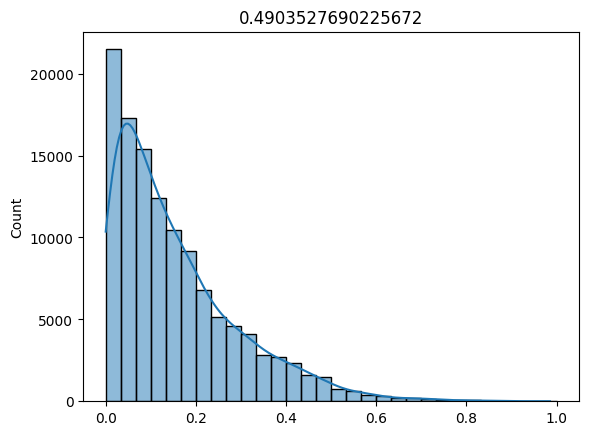

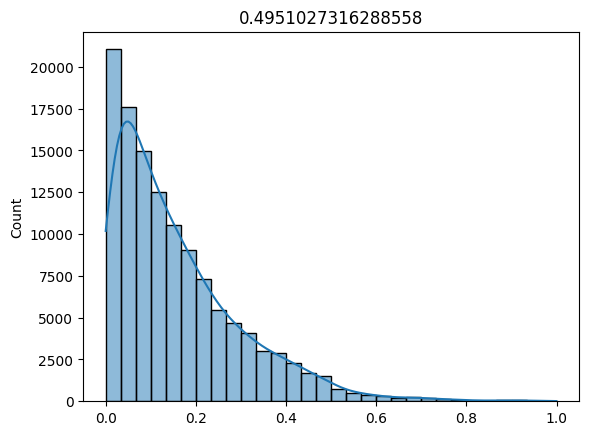

In [37]:
maxCosts = [1.25, 1.5, 2.0, 3.0, 5.0, 9.0, 17.0, 33.0, 65.0]
for maxCost in maxCosts:
    headings = df[(df["steps"] == 2000) & (df["settings.maxCost"] == maxCost)]["weightedHeadings"].explode()
    p = sns.histplot(x=[h[0]/np.pi for h in headings], weights=[h[1] for h in headings], bins=30, kde=True, binrange=(0.0, 1.0), log=False)
    # p.set_xscale('log')
    angle = np.arccos(1 / maxCost) / np.pi
    plt.title(angle)
    plt.show()


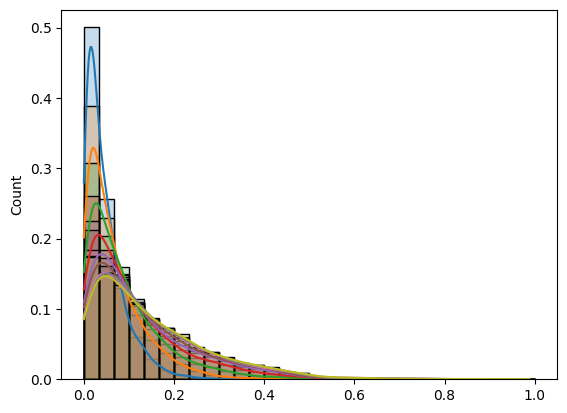

In [38]:
maxCosts = [1.25, 1.5, 2.0, 3.0, 5.0, 9.0, 17.0, 33.0, 65.0]
for maxCost in maxCosts:
    headings = df[(df["steps"] == 10000) & (df["settings.maxCost"] == maxCost)]["weightedHeadings"].explode()
    angle = np.arccos(1 / maxCost) / np.pi

    _weights = [h[1] for h in headings]
    weight_sum = sum(_weights)
    weights = [w / weight_sum for w in _weights]

    p = sns.histplot(
        x=[h[0]/np.pi for h in headings],
        weights=weights,
        bins=30, kde=True, binrange=(0.0, 1.0), log=False,
        alpha=0.25,
    )
    # plt.legend(f"angle: {angle}")
    # p.set_xscale('log')
    # plt.title(angle)
    # plt.show()


In [39]:
# for p in [0.5, 0.9, 0.95, 0.99]:
#     sns.lineplot(data=df[df["steps"] == 2000], y=f"{int(p*100)}%", x="angle", label=f"{int(p*100)}%")
# plt.legend()

In [40]:
def find_percentile(percentile, _headings):
    _headings = sorted(_headings, key=lambda h: h[0])
    weights = [h[1] for h in _headings]
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]
    i = 0
    for cw in np.cumsum(weights):
        if cw >= percentile:
            return _headings[i][0] / np.pi
        i += 1

In [41]:
if True:
    for p in [0.9, 0.95, 0.99]:
        df[f"{int(p * 100)}%"] = df.apply(lambda r: find_percentile(p, r["weightedHeadings"]), axis=1)

In [9]:
# sns.relplot(data=df, y="95%", x="angle", kind="line", hue="steps")

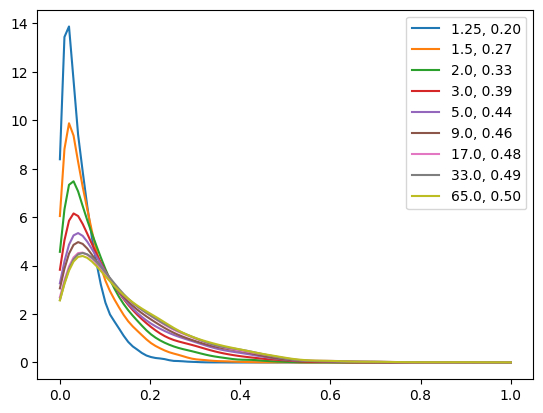

In [42]:
maxCosts = [1.25, 1.5, 2.0, 3.0, 5.0, 9.0, 17.0, 33.0, 65.0]

cutoffs = [(cutoff, []) for cutoff in [0.5, 0.9, 0.95, 0.99]]
angles = []
exponential_best_fits = []


for maxCost in maxCosts:
    
    _df = df[
        (df["steps"] == 10000) &
        (df["settings.maxCost"] == maxCost)
        # (df["settings.numLocations"] == 20)
    ]
    
    angle = np.arccos(1 / maxCost) / np.pi
    angles.append(angle)

    

    
    _headings = _df["weightedHeadings"].explode()
    _headings = _headings.to_list()
    _headings.sort(key=lambda h: h[0])

    headings = [h[0]/np.pi for h in _headings]
    # alt_headings = [h * -1 for h in headings]

    weights = [h[1] for h in _headings]

    
    total_weight = sum(weights)
    weights = [w / total_weight for w in weights]

    
    for (cutoff, l) in cutoffs:
        i = 0
        for cw in np.cumsum(weights):
            if cw >= cutoff:
                l.append(headings[i])
                break
            i += 1

    X = np.linspace(0, 1.0, 100)
    kde = scipy.stats.gaussian_kde(headings, weights=weights).pdf(X)
    # kde = scipy.stats.gaussian_kde(headings + alt_headings, weights=weights + weights)
    plt.plot(X, kde, label=f"{maxCost}, {angle:.2f}")
    plt.legend()


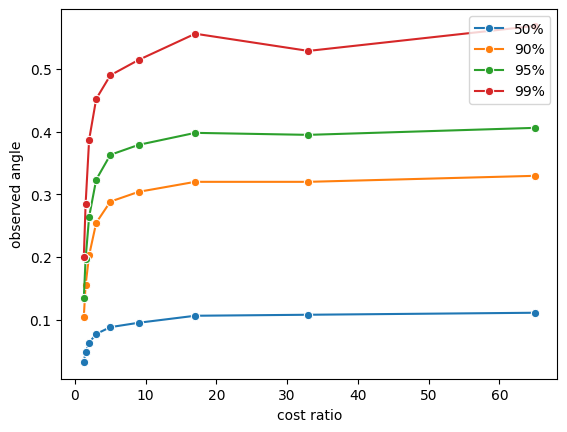

In [43]:
for c, l in cutoffs:
    sns.lineplot(x=maxCosts, y=l, marker="o", label=f"{int(100 * c)}%")
    plt.xlabel("cost ratio")
    plt.ylabel("observed angle")
    plt.legend()

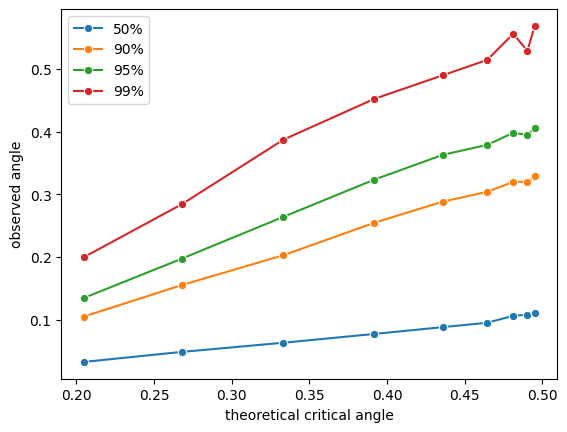

In [44]:
for c, l in cutoffs:
    sns.lineplot(x=angles, y=l, marker="o", label=f"{int(100 * c)}%")
    plt.xlabel("theoretical critical angle")
    plt.ylabel("observed angle")
    plt.legend()